In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzf -

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x


class ConvBlock11(nn.Module):

  def __init__(self):
    super(ConvBlock11, self).__init__()

    self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
    self.batch_norm1 = nn.BatchNorm3d(32)
    self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm2 = nn.BatchNorm3d(16)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm3 = nn.BatchNorm3d(8)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

  def forward(self, x):

    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

    return x


class FullNetwork11(nn.Module):

  def __init__(self, encoder, num_classes=3):
    super(FullNetwork11, self).__init__()

    self.encoder = encoder

    for param in list(self.encoder.parameters()):
        param.requires_grad = False

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
    self.batch_norm_fc = nn.BatchNorm1d(12)
    self.fc2 = nn.Linear(12, num_classes)

  def forward(self, x):

    x = self.encoder(x)

    x = self.flatten(x)
    x = F.relu(self.batch_norm_fc(self.fc1(x)))
    x = self.fc2(x)

    return x


class TheActualGRU(nn.Module):

  def __init__(self, num_classes=3):
    super(TheActualGRU, self).__init__()

    self.bgru_1 = nn.GRU(640, 640, batch_first = True, bidirectional = True) # output: x: (N,L,2∗H_out), h_n: (2∗num_layers,N,H_out​)
    self.bgru_2 = nn.GRU(1280, 200, batch_first = True, bidirectional = True)
    self.dropout_1 = nn.Dropout(p = 0.2)
    self.bgru_3 = nn.GRU(400, 50, batch_first = True, bidirectional = True)
    self.fc1 = nn.Linear(100, 50)
    self.dropout_2 = nn.Dropout(p = 0.2)
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x):
    # h0 = torch.zeros(2, x.size(0), 300).to(x.device) # defaults to zero if not provided

    x, _ = self.bgru_1(x)
    x, _ = self.bgru_2(x)
    x = self.dropout_1(x)
    x, _ = self.bgru_3(x)
    x = x[:, -1, :]
    x = self.fc1(x)
    x = self.dropout_2(x)
    x = self.fc2(x)

    return x


class CRNN(nn.Module):

  def __init__(self, tp0, tp1, tp2, tp3, tp4, tp5, bgru=None, num_classes=3):
    super(CRNN, self).__init__()

    self.tp0, self.tp1, self.tp2, self.tp3, self.tp4, self.tp5 = tp0, tp1, tp2, tp3, tp4, tp5

    if bgru is not None:
      self.bgru = bgru
    else:
      self.bgru = TheActualGRU(num_classes=3)

  def forward(self, x): # x: 4, 1, 6, 182, 218, 182

    tp0_out = self.tp0(x[:,:,0,:,:,:])
    tp1_out = self.tp1(x[:,:,1,:,:,:])
    tp2_out = self.tp2(x[:,:,2,:,:,:])
    tp3_out = self.tp3(x[:,:,3,:,:,:])
    tp4_out = self.tp4(x[:,:,4,:,:,:])
    tp5_out = self.tp5(x[:,:,5,:,:,:])

    t_out = torch.stack([tp0_out, tp1_out, tp2_out, tp3_out, tp4_out, tp5_out], dim=1)

    out = self.bgru(t_out)

    return out


In [ ]:
from torchsummary import summary

In [ ]:
model = TheActualGRU()
summary(model, (6, 640), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 6, 1280], [-1, 2, 640]]               0
               GRU-2  [[-1, 6, 400], [-1, 2, 200]]               0
           Dropout-3               [-1, 6, 400]               0
               GRU-4  [[-1, 6, 100], [-1, 2, 50]]               0
            Linear-5                   [-1, 50]           5,050
           Dropout-6                   [-1, 50]               0
            Linear-7                    [-1, 3]             153
Total params: 5,203
Trainable params: 5,203
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 82.76
Params size (MB): 0.02
Estimated Total Size (MB): 82.80
----------------------------------------------------------------


## dataset creation

In [ ]:
import re

def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

def filter_missing_data(images, labels, existing_ids):

    zipped_set = list(zip(images, labels))

    zipped_set = list(filter(lambda x: image_exists(x, existing_ids), zipped_set))

    images, labels = zip(*zipped_set)

    return images, labels

id_to_path = make_id_translator(images)

In [ ]:
def reorder_images(group, dset='adni3'):
    if dset == 'adni1':
        order_mapping = {'sc': 0, 'm06': 1, 'm12': 2, 'm18': 3, 'm24': 4, 'm36': 5}
    else:
        order_mapping = {'sc': 0, 'y1': 1, 'y2': 2, 'y3': 3, 'y4': 4, 'y5': 5}
    result = [None] * 6
    for index, row in group.iterrows():
        result[order_mapping[row['Visit']]] = row['Image Data ID']
    return result

In [ ]:
def id_to_path_with_none(id):
  if id is None:
    return None
  return id_to_path[id]

In [ ]:
import pandas as pd

testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
testing_df = testing_df[testing_df['Image Data ID'].isin(id_to_path)]

In [ ]:
## only run if you're using adni3

def replace_init(row):
  if row['Visit'] == 'init':
    return 'sc'
  else:
    return row['Visit']

testing_df['Visit'] = testing_df.apply(replace_init, axis=1)

In [ ]:
## if two classes:
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
testing_imagelist = testing_df.groupby('Subject')[['Visit', 'Image Data ID']].apply(reorder_images).rename('ImageIDs')
testing_df = testing_df[['Subject', 'Group']].drop_duplicates(['Subject']).merge(testing_imagelist, left_on='Subject',right_index=True)[['ImageIDs', 'Group']]
testing_imagelist, testing_labels = testing_df.T.to_numpy()
testing_image_paths = [[id_to_path_with_none(id) for id in sbj_list] for sbj_list in testing_imagelist]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CRNNDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path_list = self.file_paths[idx]
        label = self.labels[idx]

        images = []

        for file_path in file_path_list:

          if file_path is None:
            none_img = np.ones((182,218,182)) * -1
            images.append(none_img)
            continue

          # Load NIfTI image
          nifti_img = nib.load(file_path)

          # Get the image data
          img_data = nifti_img.get_fdata()

          # Assuming the data is in a reasonable range, you may normalize it
          max_i = img_data.max()
          min_i = img_data.min()
          img_data = (img_data - min_i) / (max_i - min_i)

          images.append(img_data)

        stacked_images = np.stack(images, axis=0)

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(stacked_images, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (182, 218, 182) -> (182, 182, 218)
        img_data = torch.FloatTensor(img_data).permute(0, 1, 4, 2, 3)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_test_encoded = le.fit_transform(testing_labels)
n_classes = len(le.classes_)

y_test_one_hot = torch.nn.functional.one_hot(torch.tensor(y_test_encoded), num_classes=n_classes).float()

# Create custom datasets
test_dataset = CRNNDataset(file_paths=testing_image_paths, labels=y_test_one_hot)

batch_size = 2
num_workers = 8

# Create data loaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
len(test_loader)

56

## Loading the pretrained model first

In [ ]:
import os
import shutil

def load_pretrained(filename='run_checkpoint.pth', num_classes=2):

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  if not os.path.isfile(filename):
    shutil.copy(src = f'/content/drive/MyDrive/Main_Data/Checkpoints3/part2/augmented_timepoints/{filename}', dst='.')

  if not torch.cuda.is_available():
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(filename)

  try:

    model.load_state_dict(checkpoint['model_state_dict'], strict=True)

  except RuntimeError as re:

    old_state = checkpoint['model_state_dict']

    new_state = model.state_dict()

    assert len(old_state.keys()) == len(new_state.keys())

    new_to_old = {}
    for kn, ko in zip(new_state.keys(), old_state.keys()):
      new_to_old[kn] = ko

    for key, value in new_state.items():

      if 'encoder' in key:
        weights = old_state[key.replace('encoder.', '')]
      else:
        weights = old_state[key]

    model.load_state_dict(new_state, strict=True)

  for param in model.parameters():
      param.requires_grad = False

  for name, param in model.named_parameters():
      if '3' in name:
        param.requires_grad = True

  return model

def load_pretrained_timeless(filename='augmented_cnn11_adni3.pth', num_classes=2):

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  savename = f'{num_classes}c_{filename}'

  if not os.path.isfile(savename):
    shutil.copy(src = f'/content/drive/MyDrive/Main_Data/Checkpoints3/part2/{savename}', dst='.')

  if not torch.cuda.is_available():
    checkpoint = torch.load(savename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(savename)

  try:

    model.load_state_dict(checkpoint['model_state_dict'], strict=True)

  except RuntimeError as re:

    old_state = checkpoint['model_state_dict']

    new_state = model.state_dict()

    assert len(old_state.keys()) == len(new_state.keys())

    new_to_old = {}
    for kn, ko in zip(new_state.keys(), old_state.keys()):
      new_to_old[kn] = ko

    for key, value in new_state.items():

      if 'encoder' in key:
        weights = old_state[key.replace('encoder.', '')]
      else:
        weights = old_state[key]

    model.load_state_dict(new_state, strict=True)

  for param in model.parameters():
      param.requires_grad = False

  for name, param in model.named_parameters():
      if '3' in name:
        param.requires_grad = True

  return model

In [ ]:
def load_whole_model(num_classes=2):

  # tp0 = load_pretrained(filename=f"{num_classes}c_timepoint-sc_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp1 = load_pretrained(filename=f"{num_classes}c_timepoint-m06_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp2 = load_pretrained(filename=f"{num_classes}c_timepoint-m12_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp3 = load_pretrained(filename=f"{num_classes}c_timepoint-m18_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp4 = load_pretrained(filename=f"{num_classes}c_timepoint-m24_cnn11_adni1.pth", num_classes=num_classes).encoder
  # tp5 = load_pretrained(filename=f"{num_classes}c_timepoint-m36_cnn11_adni1.pth", num_classes=num_classes).encoder

  tp0 = load_pretrained(filename=f"{num_classes}c_timepoint-sc_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp1 = load_pretrained(filename=f"{num_classes}c_timepoint-y1_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp2 = load_pretrained(filename=f"{num_classes}c_timepoint-y2_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp3 = load_pretrained(filename=f"{num_classes}c_timepoint-y3_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp4 = load_pretrained(filename=f"{num_classes}c_timepoint-y4_cnn11_adni3.pth", num_classes=num_classes).encoder
  tp5 = load_pretrained(filename=f"{num_classes}c_timepoint-y5_cnn11_adni3.pth", num_classes=num_classes).encoder

  if num_classes == 2 or num_classes == 3:
    model = CRNN(tp0, tp1, tp2, tp3, tp4, tp4, num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  return model

def load_whole_model_timeless(num_classes=2):

  tp0 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp1 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp2 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp3 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp4 = load_pretrained_timeless(num_classes=num_classes).encoder
  tp5 = load_pretrained_timeless(num_classes=num_classes).encoder

  if num_classes == 2 or num_classes == 3:
    model = CRNN(tp0, tp1, tp2, tp3, tp4, tp4, num_classes=num_classes)
  else:
    raise Exception('we can only classify for two or three classes')

  return model

In [ ]:
from torchsummary import summary

In [ ]:
summary(load_whole_model_timeless(num_classes=3), (1, 6, 182, 218, 182), device='cpu')

## Testing

In [ ]:
params_filename = '3c_crnn_timeless_new_adni3.pth'

In [ ]:
!cp /content/drive/MyDrive/Main_Data/Checkpoints3/part3/$params_filename .

In [ ]:
import shutil
import os

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


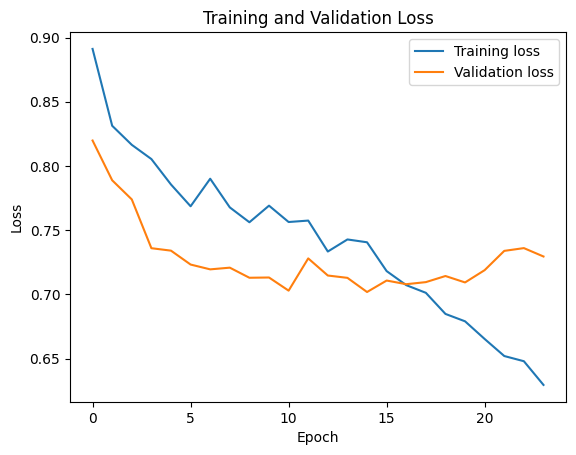

In [ ]:
import torch
import torch.optim as optim
import os

# Instantiate the model
model = load_whole_model_timeless(num_classes=3)

# Number of training epochs
num_epochs = 20

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=4e-5) #lr=0.001

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler=None, early_stopper=None)

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def pad(s, pad=10, pad_up_down=False):
    lines = s.split('\n')
    new_lines = [' ' * pad + line for line in lines]
    if pad_up_down:
        new_lines.insert(0, '\n')
        new_lines.append('\n')
    return '\n'.join(new_lines)

def get_report(y_true, y_pred, classes=None):
    confusion_arr = confusion_matrix(y_true, y_pred)
    confusion_rep = str(pd.DataFrame(confusion_arr, columns=[f'pred_{cl}' for cl in classes], index=[f'true_{cl}' for cl in classes]))
    splitter = '\n' + '='*60 + '\n'
    report = classification_report(y_true, y_pred, target_names=classes)

    return splitter + pad(confusion_rep) + splitter + report + splitter

In [ ]:
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Validation step
model.eval()

y_true_test = []
y_pred_test = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        y_true_test.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_test.extend(torch.argmax(output, dim=1).cpu().numpy())


# Testing metrics

test_report = get_report(y_true_test, y_pred_test, le.classes_)
print(test_report)

  0%|          | 0/56 [00:00<?, ?it/s]


                    pred_AD  pred_CN  pred_MCI
          true_AD         0        3         6
          true_CN         0       47        13
          true_MCI        0       16        26
              precision    recall  f1-score   support

          AD       0.00      0.00      0.00         9
          CN       0.71      0.78      0.75        60
         MCI       0.58      0.62      0.60        42

    accuracy                           0.66       111
   macro avg       0.43      0.47      0.45       111
weighted avg       0.60      0.66      0.63       111




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## save report

In [ ]:
report_name = params_filename.replace('.pth', '_report.txt')

In [ ]:
with open(report_name, 'w') as f:
  f.write(test_report)

In [ ]:
!cp $report_name /content/drive/MyDrive/Main_Data/Reports3/part3/$report_name

## Save confusion matrix

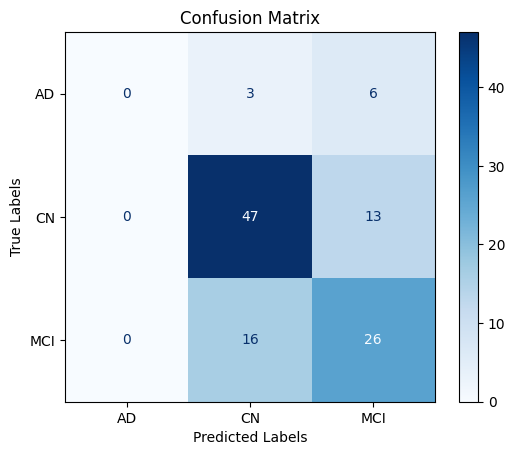

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
matrix_name = params_filename.replace('.pth', '_matrix.png')
plt.savefig(matrix_name)

In [ ]:
!cp $matrix_name /content/drive/MyDrive/Main_Data/Reports3/part3/$matrix_name